In [1]:
from agents.state import MessageState
from nodes.sql_note import sql_query_node
from nodes.context_node import context_node
from nodes.assistant_node import assistant_node
from langgraph.graph import StateGraph,START,END

In [2]:
state = MessageState()
state['question'] = "Lấy tất cả dữ liệu tử bảng khách hàng"
# state["SQL_statement"] = "SELECT * from olist.olist_customer oc"

In [9]:
graph = StateGraph(MessageState)

graph.add_node("context_node",context_node)
graph.add_node("assistant_node", assistant_node)
graph.add_node("sql_query_node",sql_query_node)
graph.add_edge(START, "context_node")
graph.add_edge("context_node", "assistant_node")
graph.add_edge("assistant_node", "sql_query_node")
graph.add_edge("sql_query_node", END)
app = graph.compile()

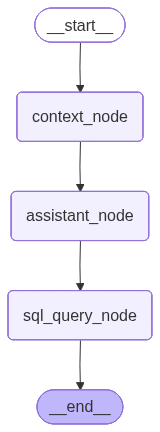

In [10]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
state = app.invoke(state)

In [12]:
state

{'question': 'Lấy tất cả dữ liệu tử bảng khách hàng',
 'system_msg': "Bạn là chuyên gia viết SQL postgres để trả lời câu hỏi tiếng Việt/Anh dựa trên mô tả cơ sở dữ liệu cung cấp.\n\nQUY TẮC BẮT BUỘC:\n1) Chỉ tạo câu lệnh SELECT hợp lệ cho postgres; không được tạo DDL/DML.\n2) Luôn ghi rõ schema trước tên bảng (schema.table). Không tự suy ra bảng/cột không có trong mô tả.\n3) Ưu tiên cột/khóa có trong mô tả. Nếu thiếu thông tin, dùng comment ngắn dạng -- TODO:<vấn đề>.\n4) Mặc định giới hạn kết quả để an toàn:\n   - postgres/mysql: dùng LIMIT 200.\n   - mssql: dùng TOP 200 hoặc OFFSET…FETCH (nếu có ORDER BY).\n5) Đặt alias cột ngắn gọn, snake_case; tránh khoảng trắng; không dùng dấu tiếng Việt trong alias.\n6) Đối với lọc thời gian mơ hồ như “gần đây”, hiểu là 6 tháng gần nhất.\n7) Xử lý NULL an toàn với COALESCE khi tính toán/ghép chuỗi.\n8) Khi cần tìm kiếm không phân biệt hoa thường:\n   - postgres: ILIKE.\n   - mysql/mssql: LOWER(col) LIKE LOWER('%kw%') (nếu cần).\n9) Chỉ TRẢ VỀ duy

In [7]:
state["SQL_statement"]

'SELECT \n    customer_id,\n    customer_unique_id,\n    customer_zip_code_prefix,\n    customer_city,\n    customer_state\nFROM \n    olist.olist_customers\nLIMIT 200;\n'

In [7]:
state["SQL_data_results"]

KeyError: 'SQL_data_results'